In [22]:
import pandas as pd
from scipy import stats
import scipy.stats as sc
import seaborn as sns
import matplotlib.pyplot as plt
import json
import numpy as np
import matplotlib.lines as lines
import matplotlib.patches as mpatches
from scipy import interpolate
from pprint import pprint

In [2]:
#path for summary of AlphaFolfd structures
reference_summary_path='../data/csv/summary_reference.csv'
isoform_summary_path='../data/csv/summary_isoform.csv'

#path for experimental structures
structure_path='../data/csv/PDB_alphafold_structure.csv'

#path for effective msa,per-residue msa and pLDDT information
neff_reference_path='../data/json/neff_reference.json'
neff_isoform_path='../data/json/neff_isoform.json'
reference_msa_path='../data/json/msa_reference.json'
isoform_msa_path='../data/json/msa_isoform.json'
reference_residue_plddt_path='../data/json/plddt_residue_reference.json'
isoform_residue_plddt_path='../data/json/plddt_residue_isoform.json'

#path for swissport alternative splicing information
swissprot_as_path='../data/json/swissprot_as.json'

In [3]:
def load_file_json(path):
    with open(path,'r') as load_f:
        file=json.load(load_f)
    return file

<span style="font-size: 20px;">Plot prediction quality: </span>

In [4]:
reference_summary=pd.read_csv(reference_summary_path)
isoform_summary=pd.read_csv(isoform_summary_path)

/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


([<matplotlib.axis.YTick at 0x14735a265340>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

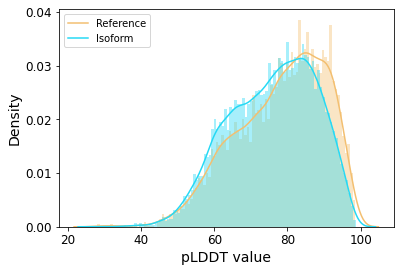

In [5]:
sns.distplot(reference_summary['plddt'],color='#F3BF70',kde_kws={'label':'reference'},bins=100,kde=True)
sns.distplot(isoform_summary['plddt'],color='#25D9F5',kde_kws={'label':'isoform'},bins=100,kde=True)
plt.legend(['Reference','Isoform'])
plt.xlabel("pLDDT value",fontsize=14)
plt.ylabel("Density",fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.yticks([0,0.01,0.02,0.03,0.04])

<span style="font-size: 20px;">Comparsion of AlphaFold and experimental PDB structures: </span>

In [6]:
structure=pd.read_csv(structure_path)
structure['type'] = structure['type'].str.capitalize()

In [7]:
def get_list(structure_df):
    tm_isoform=[]
    tm_reference=[]
    rmsd_isoform=[]
    rmsd_reference=[]
    for index in range(len(structure_df)):
        if index%2==0:
            tm_isoform.append(structure_df['TM_score_mean'][index])
            rmsd_isoform.append(structure_df['RMSD'][index])
        else:
            tm_reference.append(structure_df['TM_score_mean'][index])
            rmsd_reference.append(structure_df['RMSD'][index])
    return tm_isoform,tm_reference,rmsd_isoform,rmsd_reference
tm_isoform,tm_reference,rmsd_isoform,rmsd_reference=get_list(structure)

Ttest_indResult(statistic=-0.3041442715802864, pvalue=0.7649378673904152)


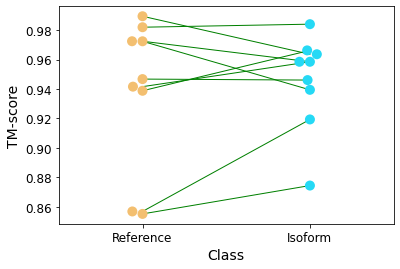

In [8]:
sns.set_palette("autumn_r")
box_colors = ['#F3BF70','#25D9F5']
sns.swarmplot(x="type",y="TM_score_mean",data=structure,palette=box_colors,size=10)
plt.xlabel("Class",fontsize=14)
plt.ylabel("TM-score",fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
for i in range(len(structure)):
    if structure['type'][i]=='Isoform':
        plt.plot([structure['type'][i-1],structure['type'][i]],[structure['TM_score_mean'][i-1],structure['TM_score_mean'][i]],'g-',linewidth=1)
print(stats.ttest_ind(tm_isoform,tm_reference))

Ttest_indResult(statistic=-1.0321547307288934, pvalue=0.31735003944574036)


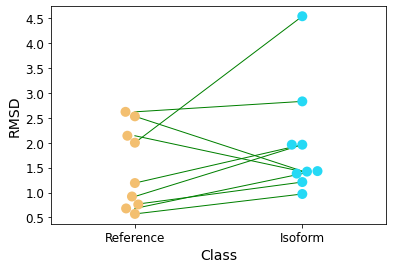

In [9]:
sns.set_palette("autumn_r")
box_colors = ['#F3BF70','#25D9F5']
sns.swarmplot(x="type",y="RMSD",data=structure,palette=box_colors,size=10) 
plt.xlabel("Class",fontsize=14)
plt.ylabel("RMSD",fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
for i in range(len(structure)):
    if structure['type'][i]=='Isoform':
        plt.plot([structure['type'][i-1],structure['type'][i]],[structure['RMSD'][i-1],structure['RMSD'][i]],'g-',linewidth=1)
print(stats.ttest_ind(rmsd_isoform,rmsd_reference))

<span style="font-size: 20px;">Plot for msa counts and pLDDT: </span>

In [10]:
neff_reference=load_file_json(neff_reference_path)
neff_isoform=load_file_json(neff_isoform_path)
reference_residue_plddt=load_file_json(reference_residue_plddt_path)
isoform_residue_plddt=load_file_json(isoform_residue_plddt_path)

In [11]:
def map_msa_quality(msa_count,quality_residue):
    msa_list=[]
    quality_list=[]
    for entry in msa_count.keys():
        if entry in quality_residue.keys():
            msa=np.mean(msa_count[entry])
            quality=np.mean(quality_residue[entry])
            msa_list.append(msa)
            quality_list.append(quality)
    return msa_list,quality_list

In [12]:
def mean_plot(msa_list,quality_list):
    msa_quality_dic={}
    for index in range(len(msa_list)):
        msa=msa_list[index]
        quality=quality_list[index]
        if msa in msa_quality_dic.keys():
            msa_quality_dic[msa].append(quality)
        else:
            msa_quality_dic[msa]=[quality]
    mean_plot_dic={}
    for msa,quality in msa_quality_dic.items():
        mean_plot_dic[msa] = sum(quality) / len(quality)
    return list(mean_plot_dic.keys()),list((mean_plot_dic.values()))

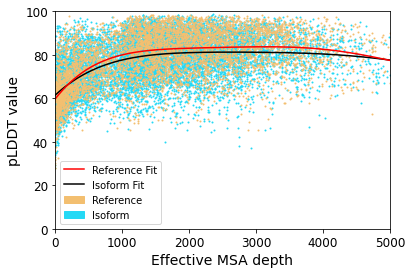

0.46041757028258873
0.4771937257364766


In [26]:
def compare_msa_class(isoform_msa,isoform_quality_residue,reference_msa,reference_quality_residue):
    msa_isoform_list,quality_isoform_list=map_msa_quality(isoform_msa,isoform_quality_residue)
    msa_reference_list,quality_reference_list=map_msa_quality(reference_msa,reference_quality_residue)
    msa_isoform_series=pd.Series(msa_isoform_list)
    quality_isoform_series=pd.Series(quality_isoform_list)
    msa_reference_series=pd.Series(msa_reference_list)
    quality_reference_series=pd.Series(quality_reference_list)
    
    # calculate the corr
    corr_isoform=quality_isoform_series.corr(msa_isoform_series,method='pearson')
    corr_reference=quality_reference_series.corr(msa_reference_series,method='pearson')
    combined_lists = list(zip(msa_isoform_list, quality_isoform_list))
    combined_lists.sort(key=lambda x: x[0])
    
    #fit the trend line
    msa_isoform_list, quality_isoform_list = zip(*combined_lists)
    msa_isoform_plot_list,quality_isoform_plot_list=mean_plot(msa_isoform_list,quality_isoform_list)
    coefficients = np.polyfit(msa_isoform_plot_list, quality_isoform_plot_list,5)
    polynomial = np.poly1d(coefficients)
    y_curve = polynomial(msa_isoform_plot_list)
    plt.plot(msa_isoform_plot_list, y_curve, color='black',label='Isoform Fit')
    plt.scatter(msa_isoform_list,quality_isoform_list,color='#25D9F5',s=1,alpha=1)
    combined_lists = list(zip(msa_reference_list, quality_reference_list))
    combined_lists.sort(key=lambda x: x[0])
    msa_reference_list, quality_reference_list = zip(*combined_lists)
    msa_reference_plot_list,quality_reference_plot_list=mean_plot(msa_reference_list,quality_reference_list)
    coefficients = np.polyfit(msa_reference_plot_list, quality_reference_plot_list,5)
    polynomial = np.poly1d(coefficients)
    y_curve = polynomial(msa_reference_plot_list)
    plt.plot(msa_reference_plot_list, y_curve, color='red',label='Reference Fit')

    plt.scatter(msa_reference_list,quality_reference_list,color='#F3BF70',s=1,alpha=1,label='Reference')
    
    #plot setting    
    plt.xlim(0,5000)
    plt.ylim(0,100)
    plt.xlabel('Effective MSA depth',fontsize=14)
    plt.ylabel('pLDDT value',fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    #legend_elements = [mpatches.Patch(color='#F3BF70', label='Reference'),mpatches.Patch(color='#25D9F5', label='Isoform'),
                       #mpatches.Patch(color='red',label='Reference Fit')]
    line_reference = lines.Line2D([0], [0], label='Reference Fit',c='red')
    line_isoform = lines.Line2D([0], [0], label='Isoform Fit',c='black')
    patch_reference = mpatches.Patch(color='#F3BF70', label='Reference')
    patch_isoform = mpatches.Patch(color='#25D9F5', label='Isoform')
    legend_elements = [line_reference, line_isoform, patch_reference, patch_isoform]
    plt.legend(handles=legend_elements) 
    #plt.legend()
    #plt.savefig('msa_count_plddt_class_neff.png',dpi=600,bbox_inches='tight')    
    plt.show()
    print(corr_isoform)
    print(corr_reference)
    return corr_isoform,corr_reference
corr_isoform,corr_reference=compare_msa_class(neff_isoform,isoform_residue_plddt,neff_reference,reference_residue_plddt)

<span style="font-size: 20px;">Comparsion of msa counts and pLDDT value across different alternative splicing regions:</span>

In [18]:
reference_msa=load_file_json(reference_msa_path)
isoform_msa=load_file_json(isoform_msa_path)

In [13]:
swissprot_as=pd.read_json(swissprot_as_path,encoding="utf-8",orient="split")

In [14]:
def add_end_position(swissprot_as_df):
    swissprot_as_df['end_position_2']=None
    for index in range(len(swissprot_as_df)):
        if swissprot_as_df['type'][index]!='Missing.':
            start_position=swissprot_as_df['start_position_1'][index]
            end_position=swissprot_as_df['end_position_1'][index]
            original_sequence=swissprot_as_df['original_sequence'][index]
            replaced_sequence=swissprot_as_df['replaced_sequence'][index]
            end_position_2=end_position-len(original_sequence)+len(replaced_sequence)
            swissprot_as_df['end_position_2'][index]=end_position_2
    return swissprot_as_df
swissprot_as=add_end_position(swissprot_as)

/tmp/ipykernel_2914784/496766125.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swissprot_as_df['end_position_2'][index]=end_position_2


In [15]:
def get_as_region(swissprot_as_df,reference_info,isoform_info):
    info_missing={}
    reference_other={}
    isoform_other={}
    isoform_info_replaced={}
    reference_info_replaced={}
    for index in range(len(swissprot_as_df)):
        isoform=swissprot_as_df['isoform'][index]
        reference=isoform.split('-')[0]
        if swissprot_as_df['type'][index]=='Missing.':
            if isoform in isoform_info.keys() and reference in reference_info.keys():
                start_position=swissprot_as_df['start_position_1'][index]
                end_position=swissprot_as_df['end_position_1'][index]+1
                info_missing[isoform]=reference_info[reference][start_position:end_position]
                isoform_other[isoform]=isoform_info[isoform]
                if swissprot_as_df['as_position'][index]=='middle':
                    reference_other[isoform]=reference_info[reference][:start_position]+reference_info[reference][end_position:]
                elif swissprot_as_df['as_position'][index]=='end':
                    reference_other[isoform]=reference_info[reference][:start_position]
                else:
                    reference_other[isoform]=reference_info[reference][end_position:]
        else:
            if isoform in isoform_info.keys() and reference in reference_info.keys():
                start_position_reference=swissprot_as_df['start_position_1'][index]-1
                end_position_reference=swissprot_as_df['end_position_1'][index]+1
                start_position_isoform=swissprot_as_df['start_position_1'][index]-1
                end_position_isoform=swissprot_as_df['end_position_2'][index]+1
                isoform_info_replaced[isoform]=isoform_info[isoform][start_position_isoform:end_position_isoform+1]
                reference_info_replaced[isoform]=reference_info[reference][start_position_reference:end_position_reference+1]
                if swissprot_as_df['as_position'][index]=='middle':
                    reference_other[isoform]=reference_info[reference][:start_position_reference]+reference_info[reference][end_position_reference:]
                    isoform_other[isoform]=isoform_info[isoform][:start_position_isoform]+isoform_info[isoform][end_position_isoform:]
                elif swissprot_as_df['as_position'][index]=='end':
                    reference_other[isoform]=reference_info[reference][:start_position_reference]
                    isoform_other[isoform]=isoform_info[isoform][:start_position_isoform]
                else:
                    reference_other[isoform]=reference_info[reference][end_position_reference:]
                    isoform_other[isoform]=isoform_info[isoform][end_position_isoform:]
    return info_missing,isoform_info_replaced,reference_info_replaced,isoform_other,reference_other

In [19]:
msa_missing,isoform_msa_replaced,reference_msa_replaced,isoform_other,reference_other=get_as_region(swissprot_as,reference_msa,isoform_msa)

In [20]:
plddt_missing,isoform_plddt_replaced,reference_plddt_replaced,isoform_plddt_other,reference_plddt_other=get_as_region(swissprot_as,reference_residue_plddt,isoform_residue_plddt)

In [21]:
def return_mean_list(dic):
    mean_list=[]
    for key in dic.keys():
        if dic[key]!=[]:
            mean_list.append(np.mean(np.array(dic[key])))
    return np.array(mean_list)

In [26]:
def compare_info_boxplot(info_missing,reference_info_replaced,isoform_info_replaced,isoform_other,reference_other,plddt=False):
    plt.figure(figsize=(12, 6))
    mean_list_missing=return_mean_list(info_missing)
    mean_list_replaced_reference=return_mean_list(reference_info_replaced)
    mean_list_replaced_isoform=return_mean_list(isoform_info_replaced)
    mean_list_other_isoform=return_mean_list(isoform_other)
    mean_list_other_reference=return_mean_list(reference_other)
    f_statistic, p_value = sc.f_oneway(mean_list_missing, 
                                       mean_list_replaced_reference, mean_list_replaced_isoform, 
                                       mean_list_other_isoform, mean_list_other_reference)
    #for i in range(200,len(mean_list_missing),200):
        #print(i)
        #print(sc.f_oneway(mean_list_missing[:i], 
                          #mean_list_replaced_reference[:i], 
                          #mean_list_replaced_isoform[:i], 
                          #mean_list_other_isoform[:i], 
                          #mean_list_other_reference[:i]))
   
    #print(p_value)
    ax = plt.subplot()
    outlier_properties = dict(marker='o', markerfacecolor='black', markersize=1, linestyle='none')
    ax.boxplot([mean_list_missing,mean_list_replaced_reference,mean_list_replaced_isoform,
                mean_list_other_isoform,mean_list_other_reference],
               notch=True, showmeans=True,flierprops=outlier_properties)
    ax.set_xticklabels(['Missing','Reference replaced','Isoform replaced','Isoform other','Reference other'],fontsize=14)
    plt.yticks(fontsize=14)
    if plddt==False:
        plt.ylabel('MSA counts',fontsize=18)
        plt.ylim(-1000,20500)
        plt.xlabel('Alternative splicing region',fontsize=18)
        #plt.savefig('compare_msa_boxplot.png',dpi=600,bbox_inches='tight')
    else:
        plt.ylabel('pLDDT value',fontsize=18)
        plt.ylim(18,102)
        plt.xlabel('Alternative splicing region',fontsize=18)
        #plt.savefig('compare_plddt_boxplot.png',dpi=600,bbox_inches='tight')
    return True

200
F_onewayResult(statistic=27.520019391344892, pvalue=1.0773990397255782e-21)
400
F_onewayResult(statistic=69.98015932906648, pvalue=1.6282215660139978e-55)
600
F_onewayResult(statistic=86.27091918241041, pvalue=1.8618846975604672e-69)
800
F_onewayResult(statistic=115.77836883365647, pvalue=1.4774977063855778e-93)
1000
F_onewayResult(statistic=162.33739303179848, pvalue=7.880407429096323e-131)
1200
F_onewayResult(statistic=204.99232491163153, pvalue=4.713388598952094e-165)
1400
F_onewayResult(statistic=250.99288498721094, pvalue=8.443735065614293e-202)
1600
F_onewayResult(statistic=286.89909716336894, pvalue=6.961164704764652e-231)
1800
F_onewayResult(statistic=378.27636136327123, pvalue=1.3370544768972259e-301)
2000
F_onewayResult(statistic=444.4469537033111, pvalue=0.0)
2200
F_onewayResult(statistic=504.8282853055301, pvalue=0.0)
2400
F_onewayResult(statistic=572.2987788458163, pvalue=0.0)
2600
F_onewayResult(statistic=617.6313302713907, pvalue=0.0)
2800
F_onewayResult(statistic=66

True

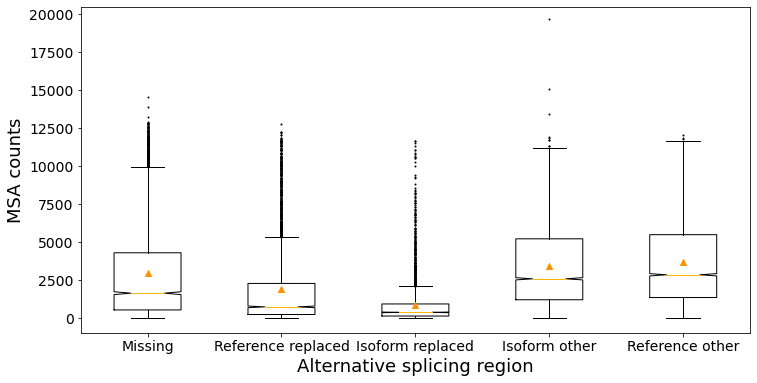

In [27]:
compare_info_boxplot(msa_missing,reference_msa_replaced,isoform_msa_replaced,isoform_other,reference_other)

200
F_onewayResult(statistic=59.96009180080873, pvalue=2.1388313324919573e-45)
400
F_onewayResult(statistic=135.05265087996955, pvalue=3.300165234786379e-102)
600
F_onewayResult(statistic=201.82976915393638, pvalue=1.9286747230550926e-153)
800
F_onewayResult(statistic=287.47464624815024, pvalue=1.6044332011985748e-217)
1000
F_onewayResult(statistic=393.44439498017886, pvalue=5.039663102259847e-295)
1200
F_onewayResult(statistic=475.6670963945403, pvalue=0.0)
1400
F_onewayResult(statistic=578.0422109834205, pvalue=0.0)
1600
F_onewayResult(statistic=697.896822386959, pvalue=0.0)
1800
F_onewayResult(statistic=806.1946310971705, pvalue=0.0)
2000
F_onewayResult(statistic=909.7287353306147, pvalue=0.0)
2200
F_onewayResult(statistic=1020.5002908043514, pvalue=0.0)
2400
F_onewayResult(statistic=1120.9854857161063, pvalue=0.0)
2600
F_onewayResult(statistic=1204.6711718425668, pvalue=0.0)
2800
F_onewayResult(statistic=1317.1869208253129, pvalue=0.0)
3000
F_onewayResult(statistic=1390.44019141305

True

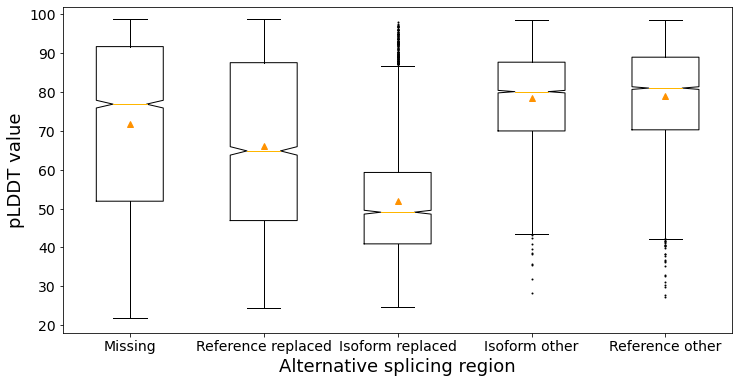

In [28]:
compare_info_boxplot(plddt_missing,reference_plddt_replaced,isoform_plddt_replaced,isoform_plddt_other,reference_plddt_other,plddt=True)